# 데이터 불러오기

In [1]:
import sys
import warnings
import os
#Delete warning message
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
import matplotlib.pyplot as plt
import pandas as pd


columns = ['timestamp', 'heartRate', 'gyroscopeX', 'gyroscopeY', 'gyroscopeZ', 'gyroscopeRotationX', 'gyroscopeRotationY', 'gyroscopeRotationZ', 'light']

data = {}
data["drink"] = []
data["workout"] = []

def read(htype, name):
    global columns
    temp = pd.read_csv(name + ".csv")
    # ' timestamp'처럼 공백이 들어간 컬럼 이름 수정
    temp.columns = columns
    # 시간 데이터를 분 단위로 변경
    temp["timestamp"] = (temp["timestamp"] - temp.loc[0, "timestamp"]) / 1000 / 60
    data[htype].append({'name':name, 'data': temp})
    
read("drink","[drink, p1] Health-2019-10-29 23-56-55")
read("drink","[drink, p2] Health 2019-10-29 22_12_32")
read("drink","[drink, p3] Health 2019-10-31 22_50_39")
read("drink","[drink, p6] Health-2019-11-10 22-11-20")
read("workout", "[work out, 30m] Health-2019-10-27 21-01-23")

# 심박수 데이터 분석

## 원시 데이터 확인

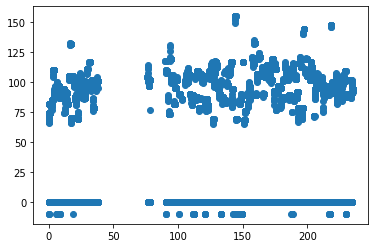

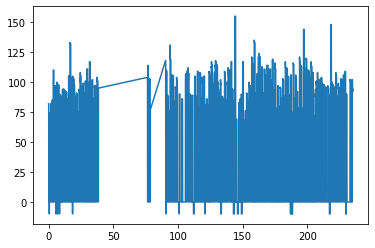

In [3]:
temp = data['drink'][0]['data']
plt.scatter(temp["timestamp"], temp["heartRate"])
plt.show()

plt.plot(temp["timestamp"], temp["heartRate"])
plt.show()

**결과 (확인된 문제)**

- 심박수 측정중에는 0 이하의 값이 출력되는 것을 확인할 수 있음.
- 심박수가 잘못 측정되어 크게 변동하는 경우(outlier)가 존재함.
- 너무 자주 큰 범위로 변동하는 데이터는 곧바로 활용할 수 없으니 이를 linear하게 정리해야함.
- 알수 없는 이유로 중간에 데이터가 비어있는 경우 발생.

## 심박수 데이터 프리프로세싱

위에 나열된 4개의 문제를 해결하기 위한 방법으로 머신러닝을 활용하여 데이터를 정리

In [4]:
import numpy as np

from sklearn.linear_model import Ridge

from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

def Preprocessing(X):
    X = np.array(X)
    X2 = X * X
    X3 = X * X * X
    X4 = X * X * X * X
    X5 = X * X * X * X * X
    return np.column_stack([X, X2, X3, X4, X5])
    
def HeartRate(data):
    temp = data.copy()
    
    
    # Remove duplicated data in hreat rate or null data
    index_list = []
    last = 0
    for index, row in temp.iterrows():
        if (row["heartRate"] > 0 and last <= 0):
            index_list.append(index)
            
        last = row["heartRate"]

    temp = temp.loc[index_list]

    
    # Find Linear Curve
    X = np.array(temp["timestamp"]).reshape(-1, 1)
    Y = np.array(temp["heartRate"]).reshape(-1, 1)
    
    rid = Ridge(alpha=90)
    rid.fit(Preprocessing(X), Y)
    plt.scatter(temp["timestamp"], temp["heartRate"], c='red')

    new_X_range = np.arange(0, temp["timestamp"].max(), dtype=np.float64)
    new_X = Preprocessing(new_X_range.reshape(-1,1))
    plt.plot(new_X_range, rid.predict(new_X),c='gray')
    

    # Find Outlier data
    cluster = DBSCAN(eps=23, min_samples=8).fit_predict(np.column_stack([X,Y]))
    
    # Remove Outlier data
    temp = temp.loc[cluster != -1]
    
    # Fine Linear Curve without outlier data
    X = np.array(temp["timestamp"]).reshape(-1, 1)
    Y = np.array(temp["heartRate"]).reshape(-1, 1)
    rid = Ridge(alpha=90)
    rid.fit(Preprocessing(X), Y)
    
    new_X_range = np.arange(0, temp["timestamp"].max(), dtype=np.float64)
    new_X = Preprocessing(new_X_range.reshape(-1,1))
    
    plt.scatter(temp["timestamp"], temp["heartRate"], c='c')
    plt.plot(new_X_range, rid.predict(new_X), c='blue')
    
    # In 10 minutes, Display heart rate using marker 'star'
    plt.scatter([10], rid.predict(Preprocessing([10])), c='fuchsia', marker='*', s=500)
    
    plt.show()

## 심박수 데이터 결과

### 그래프 설명
- 각 포인트 : 심박수 데이터
- 빨간색 포인트 : Outlier
- 별 모양 포인트: 10분 시점의 심박수 데이터
- 회색 곡선: 아웃라이어 포함되어 있는 예측 곡선
- 파란 곡선 : 아웃라이어 제거된 곡선

### 결과
- 음주 데이터에서 초기 10분을 음주 전 심박수로 판단했을 때
- 30 ~ 40 분 이후 심박수 평균이 증가하는 것을 볼 수 있음

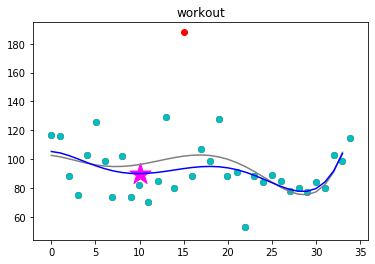

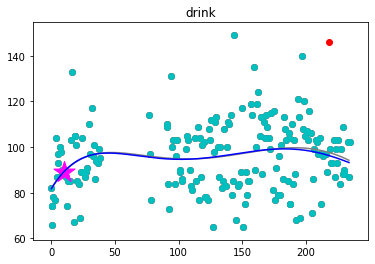

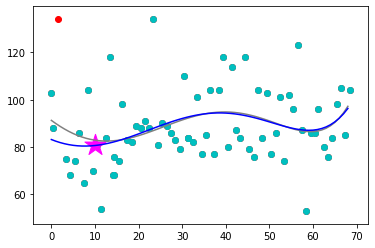

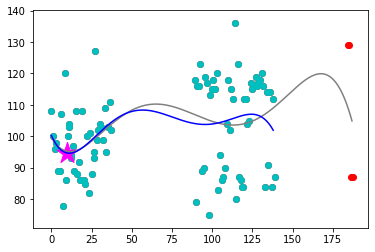

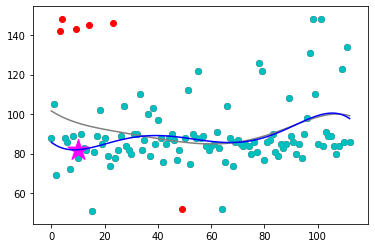

In [5]:
plt.title("workout")
HeartRate(data['workout'][0]['data'])

plt.title("drink")
HeartRate(data['drink'][0]['data'])
HeartRate(data['drink'][1]['data'])
HeartRate(data['drink'][2]['data'])
HeartRate(data['drink'][3]['data'])

# 스마트워치에 측정된 빛 센서 분석

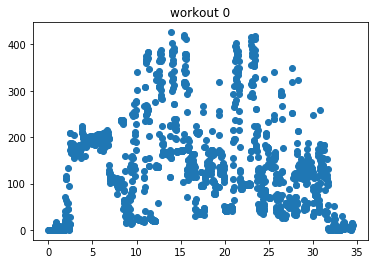

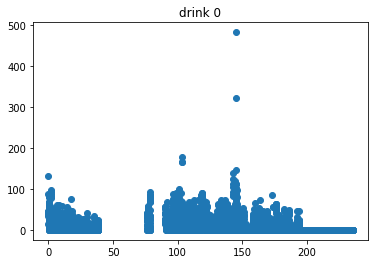

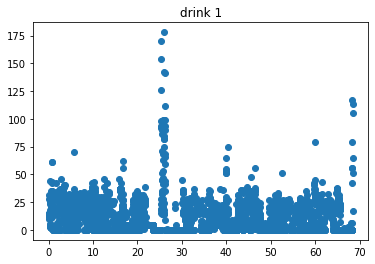

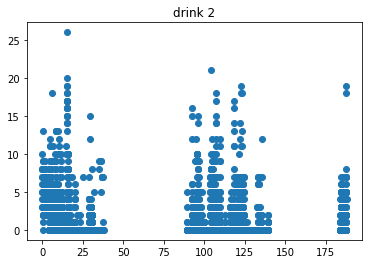

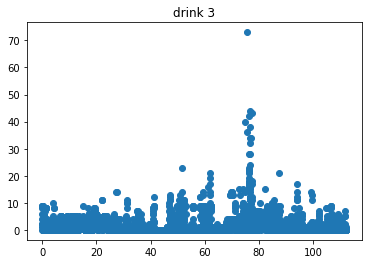

In [6]:
def display_scatter(htype, no):
    temp = data[htype][no]['data']
    plt.scatter(temp["timestamp"], temp["light"])
    plt.title(htype + " " + str(no))
    plt.show()

# 실내에서는 0~500정도의 빛을 감지   (여기에서 가장 끝 부분은 야외)
display_scatter('workout', 0)

# 대부분의 음주 환경은 0~150 이내의 빛이 있는 장소에서 진행
# 이 자체를 핵심 feature로 사용할 수는 없지만, 적어도 음주 측정을 보조하는 장치로 활용될 수 있음
# 어두운 환경에서 운동하는 경우는 흔치 않기때문에

display_scatter('drink', 0)
display_scatter('drink', 1)
display_scatter('drink', 2)
display_scatter('drink', 3)

## Light 데이터 결과

- 불이 켜진 실내에서는 0~500정도의 빛을 감지 (from 'workout0 data') 
- 이 데이터에서 양쪽 끝 부분은 실외 데이터


- 대부분의 음주 환경은 0~150 이내의 빛이 감지되었음을 알 수 있음.
- 이 자체는 핵심 Feature로 사용할 수는 없지만, 적어도 음주 측정을 보조하는 하나의 특징으로 활용할 수 있을 것으로 예상
- (어두운 환경에서 운동하는 케이스 등은 없기 때문에)